# <center style="background-color:#23967F;color: white; vertical-align: middle; padding:10px 5px;\">1-Packges and libraries</center>

In [2]:
#Musts
import pandas as pd
import numpy as np
from datetime import datetime
import math
import itertools

# plotting and graphs
import matplotlib.pyplot as plt
import plotly.express as px

# analysis
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

#Models(forcasting)
from statsmodels.tsa.ar_model import AutoReg,ar_select_order
from statsmodels.tsa.arima.model import ARIMA

# my functions
from analysis import qq_plot,hist_plot,acf_pacf_plot,seasonal_decomp
from data import data_cleaning
from models import arima_res

# <center style="background-color:#23967F;color: white; vertical-align: middle; padding:10px 5px;\">2-Data</center>

In [3]:
df_orginal,df,df_train,df_test=data_cleaning("btc",split_point=-447)

In [3]:
adful_result = adfuller(df.price)
print('ADF Statistic: %f' % adful_result[0])
print('p-value: %f' % adful_result[1])

ADF Statistic: -1.611968
p-value: 0.476943


#  <center style="background-color:#23967F;color: white; vertical-align: middle; padding:10px 5px;\">3-Analysis</center>

## <center style="background-color:#F06543;color: white; vertical-align: middle; padding:5px px;\">a- QQ-plot</center>

/tmp/ipykernel_10101/3475350422.py:2: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



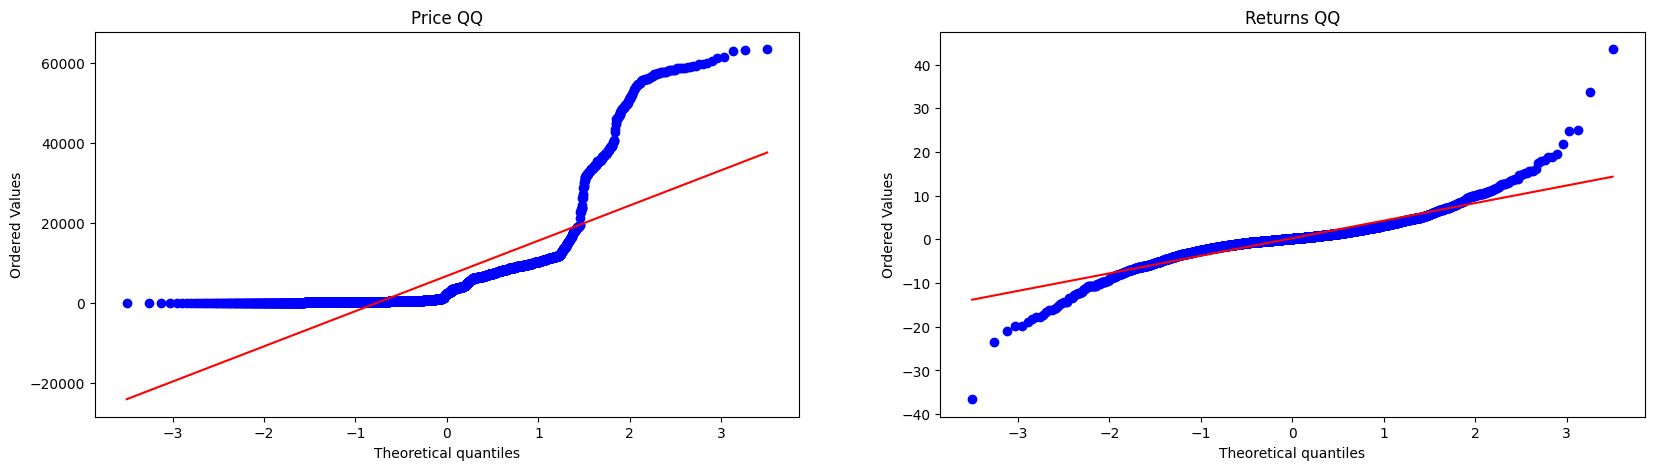

In [15]:
hist_fig=qq_plot(df_train)
hist_fig.show()

## <center style="background-color:#F06543;color: white; vertical-align: middle; padding:5px px;\">B- Autocorrelation and partial Autocorrelation</center>

/tmp/ipykernel_10101/1495827748.py:2: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



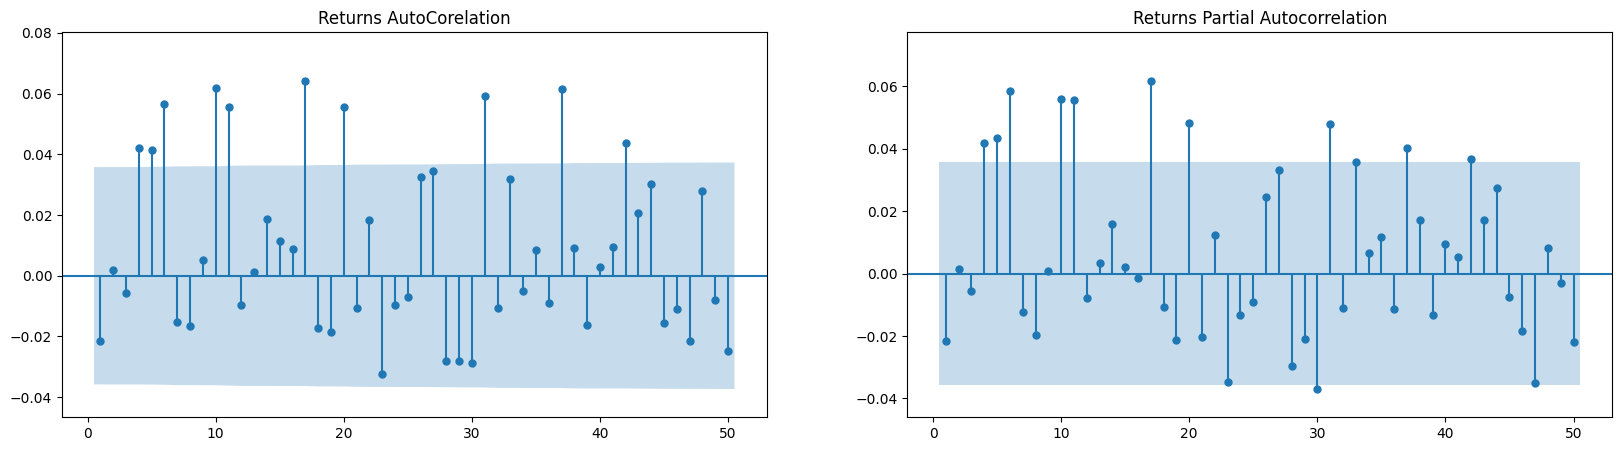

In [16]:
fig_ret_acf=acf_pacf_plot(df_train.returns,"Returns",lags=50)
fig_ret_acf.show()

/tmp/ipykernel_10101/1077358589.py:2: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



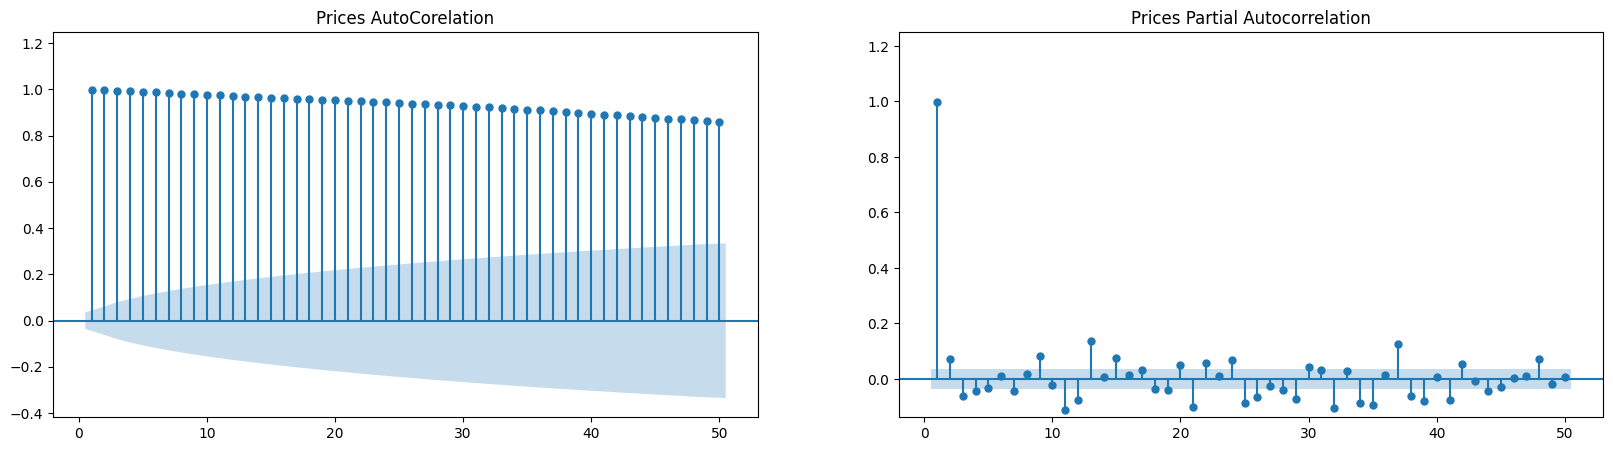

In [17]:
fig_price_acf=acf_pacf_plot(df_train.price,"Prices",lags=50)
fig_price_acf.show()

## <center style="background-color:#F06543;color: white; vertical-align: middle; padding:5px px;\">C- Histogram</center>

/tmp/ipykernel_10101/3287358936.py:2: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



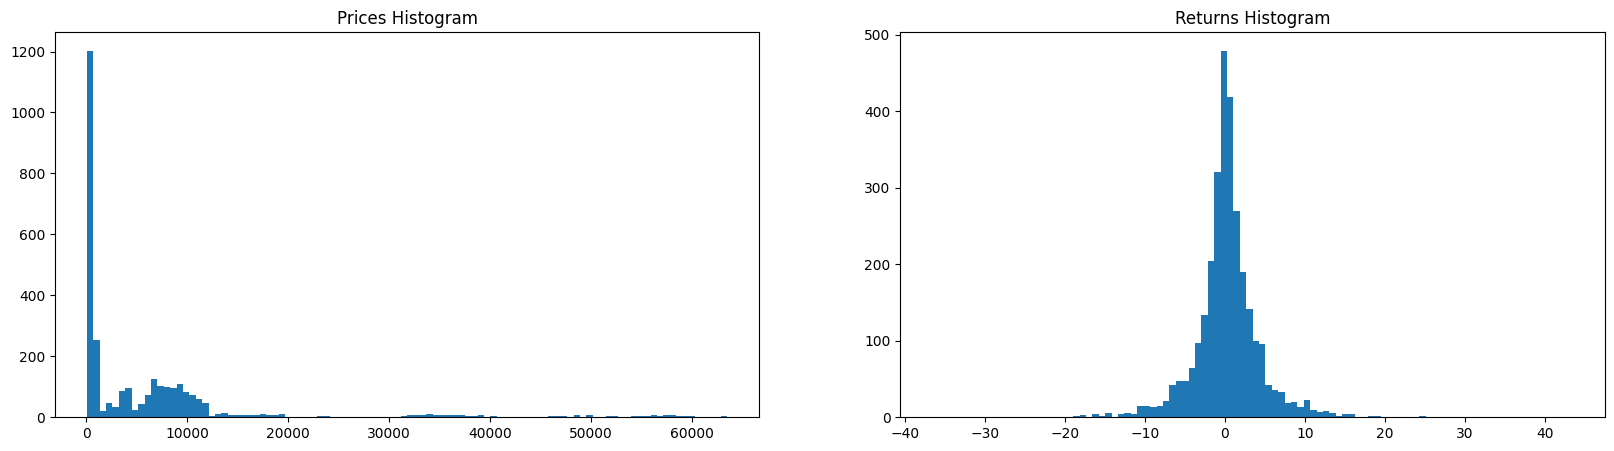

In [18]:
fig_hist=hist_plot(df_train,bins=100)
fig_hist.show()

## <center style="background-color:#F06543;color: white; vertical-align: middle; padding:5px px;\">D- Naive additive seasonal decompstion</center>

/tmp/ipykernel_10101/1482085756.py:2: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



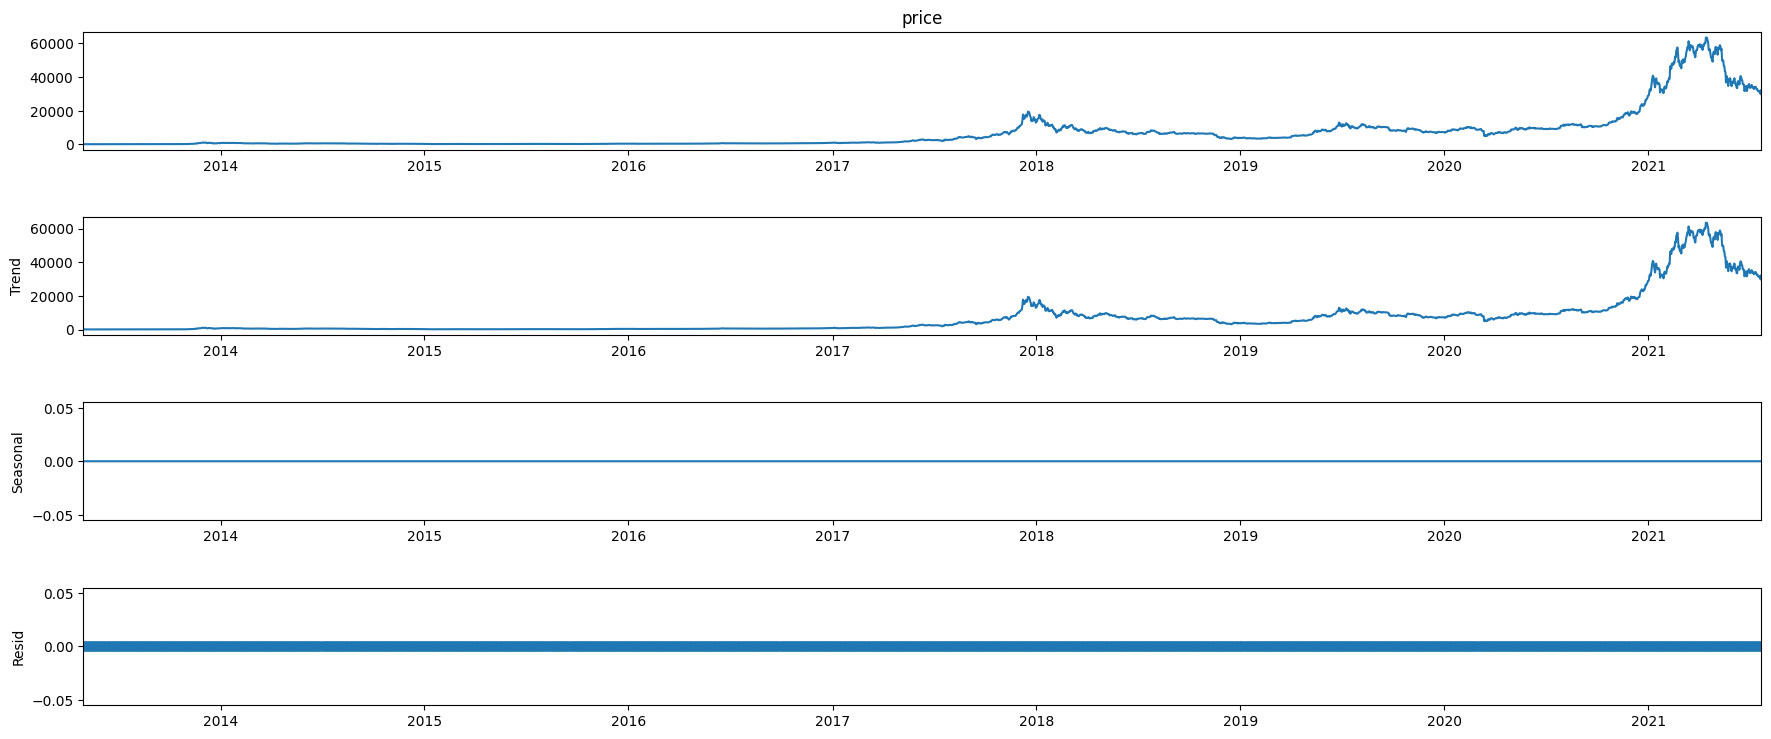

In [19]:
s_dec_add = seasonal_decomp(df_train,"price")
s_dec_add.show()

/tmp/ipykernel_10101/3088045182.py:2: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



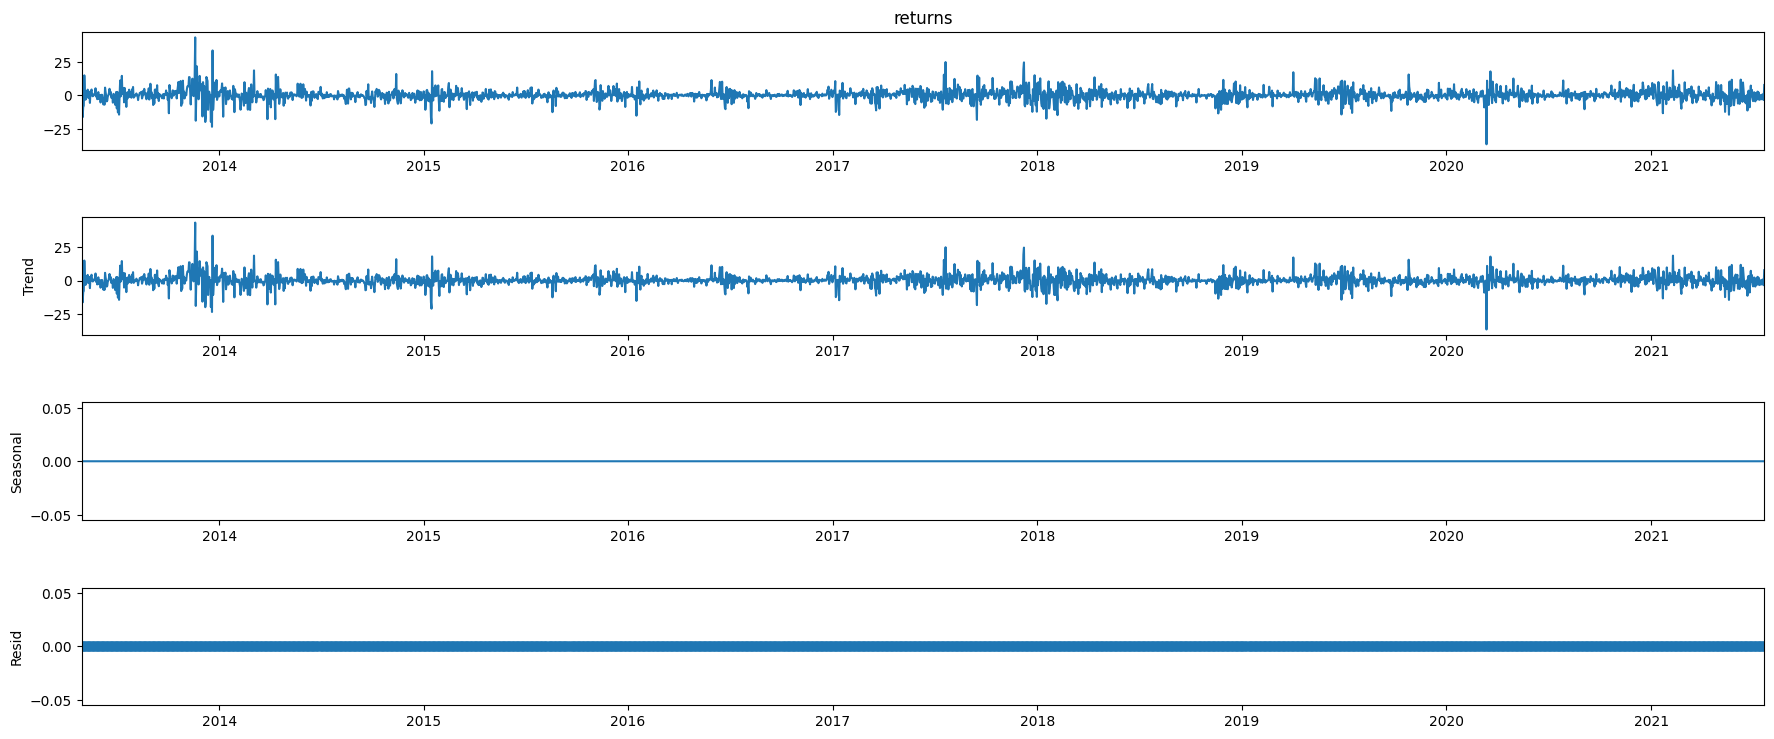

In [20]:
s_dec_add = seasonal_decomp(df_train,"returns")
s_dec_add.show()

# <center style="background-color:#23967F;color: white; vertical-align: middle; padding:10px 5px;\">4-Models</center>